## XGBoost Outlier Detection (XGBOD)
* Supervised learning can target better known outliers, however, it may never find unknown outliers. Instead, unsupervised learning can target easily new outliers, but will bring a lower prediction since we don't know the labels/targets.
* There is a way of combining both approaches -> Representation Learning.
* REPRESENTATION LEARNING or UNSUPERVISED FEATURE ENGINEERING: It is a ML approach that discover data representations for features. Which means that raw data can be represented by new features. 
- - Techniques such as PCA and autoencoders possess these capabilities.
* The idea is to use NEW data to represent the ORIGINAL data.
*
* For example, the Outlier Scores of unsupervised learning are ways to represent the ORIGINAL data. Can we use them as the input features for a supervised learning model?
- - BORE ( Bagged Outlier Representation Ensemble ).
* If so, they will provide a better predictive outcome for outliers.

### Prepare the data set

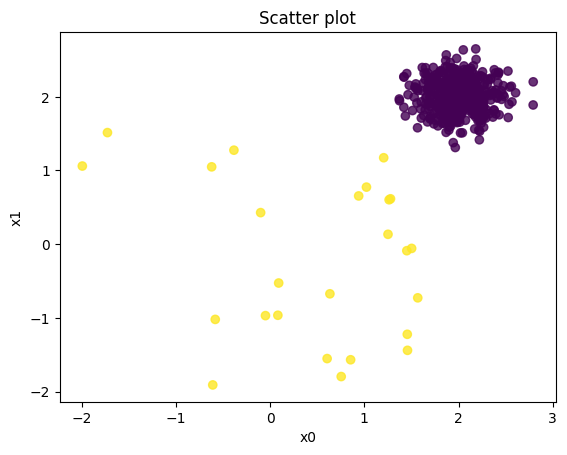

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils_od import count_stat, confusion_matrix, confusion_matrix_threshold,plot_data ,descriptive_stat_threshold 
from pyod.utils.data import generate_data

contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

### Build the model
* Different outliers, with different features, must be all labeled as 1 in a binary classification problem; ex: Logistic Regression as used by BORE.
* XGBoost has proved to handle imbalanced data sets better than other ensemble methods.
- - It also mitigates overfitting with its built-in regularization in its loss function.
- - Allows for parallelization.
* XGBoostOutlierDetection ( XGBOD ) STEPS:
1. Apply unsupervised learning to create new features, called Transformed Outlier Scores ( TOS ). XGBOD allows to use:
- - KNN, AvgKNN, LOF, iForest, HBOS and OCSVM.
2. Concatenate the new features with the original features, then apply Pearson's correlation coefficients to keep ONLY useful non redundant features.
3. Trains a XGBoost classifier.
4. It allows for further Pruning and can also provide future importance rankings.
*
* In this case, since it is a supervised approach, we will not look for a Threshold Visually.


In [3]:
from pyod.models.xgbod import XGBOD

# Fit the Data set to the model, in order to find the best coefficients that explain the labels.
xgbod = XGBOD(random_state=100) 
xgbod.fit(X_train,y_train)

/Users/mark/miniconda3/envs/rin/lib/python3.8/site-packages/pyod/models/base.py:431: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[14:57:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBOD(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1,
   estimator_list=[KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2,
  radius=1.0), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=1, no..._features=1.0,
    max_samples='auto', n_estimators=200, n_jobs=1, random_state=100,
    verbose=0)],
   gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
   min_child_weight=1, n_estimators=100, n_jobs=1, nthread=None,
   objective='binary:logistic', random_state=100, reg_alpha=0,
   reg_lambda=1, scale_pos_weight=1, silent=True,
   standardization_flag_list=[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False,

In [6]:
# get the prediction labels and outlier scores of the training data
y_train_pred = xgbod.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores_raw = xgbod.decision_scores_  # raw outlier scores
y_train_scores = xgbod.decision_function(X_train)

# get the prediction on the test data
y_test_pred = xgbod.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = xgbod.decision_function(X_test)  # outlier scores


print("The training data:", count_stat(y_train_pred))
print("The test data:", count_stat(y_test_pred))

The training data: {0: 475, 1: 25}
The test data: {0: 475, 1: 25}


In [16]:
y_train_scores_raw_pd = pd.DataFrame(y_train_scores_raw, columns = ["XGBoost Scores"]).sort_values("XGBoost Scores", ascending=False)

In [17]:
y_train_scores_raw_pd.head()

,XGBoost Scores
499,0.96581
475,0.96581
479,0.96581
480,0.96581
481,0.96581


In [4]:
confusion_matrix(y_train, y_train_pred)

Pred,0.0,1.0
Actual,,
0.0,475,0
1.0,0,25


In [5]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Pred': y_test_pred})
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0.0,1.0
Actual,,
0.0,475,0
1.0,0,25


### Understand Parameters
* estimator_list: Mention all unsupervised techniques available for Unsupervised Feature Egnineering.

In [6]:
xgbod.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'estimator_list': [KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=1, n_neighbors=1, novelty=True, p=2),
  KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=3, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=1, n_neighbors=3, novelty=True, p=2),
  KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, 

In [7]:
# Let's see how many '0's and '1's.
df_train = pd.DataFrame(X_train)
df_columns = df_train.columns
df_train['pred'] = y_train_pred
df_train['Group'] = np.where(df_train['pred']==1, 'Outlier','Normal')

# Now let's show the summary statistics:
cnt = df_train.groupby('Group')['pred'].count().reset_index().rename(columns={'pred':'Count'})
cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
stat = df_train.groupby('Group').mean().reset_index() # The avg.
cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together

,Group,Count,Count %,0,1,2,3,4,5,pred
0,Normal,475,95.0,2.003067,2.011302,2.006399,1.991409,2.008367,1.984887,0.0
1,Outlier,25,5.0,0.453548,-0.209294,-0.474818,-0.231157,-0.034642,-0.055947,1.0
